# Data School GeoPandas Notebook 

Introduction to the GeoPandas library using NYC Open Data and Census data

GeoPandas can be tricky to install on your local machine. If you don't have it already it may be best to follow along on google colab: 

https://colab.research.google.com/notebooks/welcome.ipynb#recent=true

In [145]:
# for google colab ONLY: 

#!pip install geopandas
#!pip install descartes
#!pip install mapclassify


In [146]:
#import libraries 

import geopandas as gp 
import shapely
import fiona
from fiona.crs import from_epsg
import requests
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#set pandas options so all columns will show
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

### GeoPandas

GeoPandas is a relatively simple python library that many people find intuitive as it behaves like Pandas in a lot of ways.

http://geopandas.org/#

In [147]:
#https://data.cityofnewyork.us/Housing-Development/Active-Projects-Under-Construction/8586-3zfm
#read in dataset from NYC Open Data  

url = 'https://data.cityofnewyork.us/api/views/8586-3zfm/rows.csv?accessType=DOWNLOAD'

active = pd.read_csv(url)

active.head()

,School Name,BoroughCode,Geographical District,Project Description,Construction Award,Project type,Building ID,Building Address,City,Postcode,Borough,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location 1,Data As Of
0,P.S. 101 - BROOKLYN,K,21,Addition,65999000.0,CAP,K101,2360 BENSON AVENUE,Brooklyn,11214.0,BROOKLYN,40.597863,-73.991693,11.0,47.0,302.0,3185973.0,3.068750e+09,Bensonhurst East ...,"(40.597863, -73.991693)",NaN
1,P.S./I.S. 338 - BROOKLYN,K,22,Demo,739309.0,CAP,K338,510 CONEY ISLAND AVE,Brooklyn,11218.0,BROOKLYN,40.645199,-73.970520,12.0,40.0,492.0,3124797.0,3.053420e+09,Kensington-Ocean Parkway ...,"(40.645199, -73.97052)",NaN
2,P.S./I.S. 338 - BROOKLYN,K,22,New,67683691.0,CAP,K338,510 CONEY ISLAND AVE,Brooklyn,11218.0,BROOKLYN,40.645199,-73.970520,12.0,40.0,492.0,3124797.0,3.053420e+09,Kensington-Ocean Parkway ...,"(40.645199, -73.97052)",NaN
3,PRE-K CENTER @ 369 93RD STREET - BROOKLYN,K,20,New,27637000.0,CAP,K613,369 93RD STREET,Brooklyn,11209.0,BROOKLYN,40.618041,-74.031381,10.0,43.0,58.0,3155119.0,3.061030e+09,Bay Ridge ...,"(40.618041, -74.031381)",NaN
4,PRE-K CENTER @ 219 25TH STREET - BROOKLYN,K,15,Lease,8464400.0,CAP,K661,219 25TH STREET,Brooklyn,11232.0,BROOKLYN,40.659882,-73.997016,7.0,38.0,101.0,3336859.0,3.006520e+09,Sunset Park West ...,"(40.659882, -73.997016)",NaN


In [148]:
active.shape

(2227, 21)

In [149]:
active.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 21 columns):
School Name              2224 non-null object
BoroughCode              2227 non-null object
Geographical District    2227 non-null int64
Project Description      2224 non-null object
Construction Award       2227 non-null float64
Project type             2227 non-null object
Building ID              2227 non-null object
Building Address         2227 non-null object
City                     2227 non-null object
Postcode                 2222 non-null float64
Borough                  2219 non-null object
Latitude                 2219 non-null float64
Longitude                2219 non-null float64
Community Board          2219 non-null float64
Council District         2219 non-null float64
Census Tract             2219 non-null float64
BIN                      2209 non-null float64
BBL                      2209 non-null float64
NTA                      2219 non-null object
Location 1 

#### You can create a GeoDataFrame from a regular Pandas DataFrame if you have lat/long pairs 

C:\Users\kvoorhees\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\kvoorhees\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


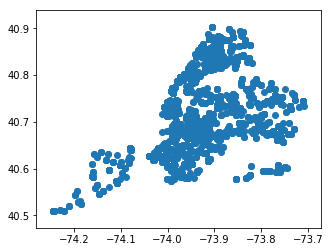

In [150]:
#create a "geography" from lat and long columns

active_geo = active.dropna(subset=['Latitude','Longitude'])
active_geo['lonlat'] = list((zip(active_geo.Longitude, active_geo.Latitude)))
active_geo['geometry'] = active_geo[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
active_geo = gp.GeoDataFrame(active_geo)

active_geo.plot()

In [151]:
active_geo.crs = from_epsg(4326)

### here we pull in a relevant polygon shapefile to give context to our map 

You can also read in more detailed base-maps 

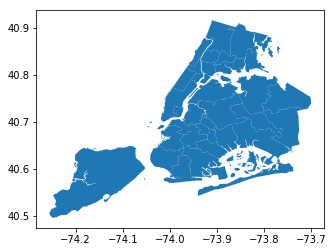

In [152]:
#https://data.cityofnewyork.us/Education/School-Districts/r8nu-ymqj#revert
#read in shapefile of nyc school districts from nyc open data

url = 'https://data.cityofnewyork.us/api/geospatial/r8nu-ymqj?method=export&format=Shapefile'

sd = gp.GeoDataFrame.from_file(url)

sd.plot();

In [153]:
#check so see if crs matches
sd.crs

{'init': 'epsg:4326'}

In [154]:
#set both geodataframes to ny state plane projection
#active_geo.to_crs(epsg=2263, inplace=True)
#sd.to_crs(epsg=2263, inplace=True)

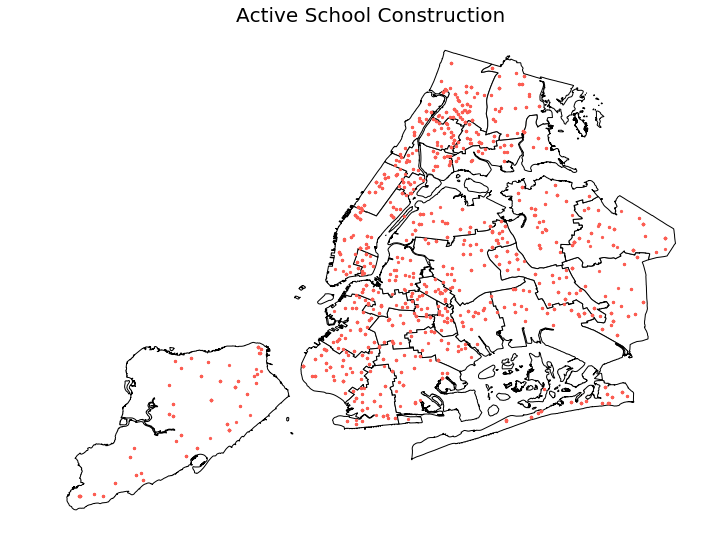

In [155]:
#plot school construction over school districts
#I don't include lat/long axes here b/c nyc borough shapes are easily recognizable

fig, ax = plt.subplots(figsize=(12,12))
ax.set_aspect('equal')
ax.axis('off')
plt.title("Active School Construction", fontsize=20)

sd.plot(facecolor='w', edgecolor='k', ax=ax)

active_geo.plot(c='#FC5D52', markersize=5,  ax=ax);


In [156]:
active_geo.head()

,School Name,BoroughCode,Geographical District,Project Description,Construction Award,Project type,Building ID,Building Address,City,Postcode,Borough,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location 1,Data As Of,lonlat,geometry
0,P.S. 101 - BROOKLYN,K,21,Addition,65999000.0,CAP,K101,2360 BENSON AVENUE,Brooklyn,11214.0,BROOKLYN,40.597863,-73.991693,11.0,47.0,302.0,3185973.0,3.068750e+09,Bensonhurst East ...,"(40.597863, -73.991693)",NaN,"(-73.99169300000001, 40.597863000000004)",POINT (-73.99169300000001 40.597863)
1,P.S./I.S. 338 - BROOKLYN,K,22,Demo,739309.0,CAP,K338,510 CONEY ISLAND AVE,Brooklyn,11218.0,BROOKLYN,40.645199,-73.970520,12.0,40.0,492.0,3124797.0,3.053420e+09,Kensington-Ocean Parkway ...,"(40.645199, -73.97052)",NaN,"(-73.97052, 40.645199)",POINT (-73.97051999999999 40.645199)
2,P.S./I.S. 338 - BROOKLYN,K,22,New,67683691.0,CAP,K338,510 CONEY ISLAND AVE,Brooklyn,11218.0,BROOKLYN,40.645199,-73.970520,12.0,40.0,492.0,3124797.0,3.053420e+09,Kensington-Ocean Parkway ...,"(40.645199, -73.97052)",NaN,"(-73.97052, 40.645199)",POINT (-73.97051999999999 40.645199)
3,PRE-K CENTER @ 369 93RD STREET - BROOKLYN,K,20,New,27637000.0,CAP,K613,369 93RD STREET,Brooklyn,11209.0,BROOKLYN,40.618041,-74.031381,10.0,43.0,58.0,3155119.0,3.061030e+09,Bay Ridge ...,"(40.618041, -74.031381)",NaN,"(-74.03138100000001, 40.618041)",POINT (-74.03138100000001 40.618041)
4,PRE-K CENTER @ 219 25TH STREET - BROOKLYN,K,15,Lease,8464400.0,CAP,K661,219 25TH STREET,Brooklyn,11232.0,BROOKLYN,40.659882,-73.997016,7.0,38.0,101.0,3336859.0,3.006520e+09,Sunset Park West ...,"(40.659882, -73.997016)",NaN,"(-73.997016, 40.659882)",POINT (-73.997016 40.659882)


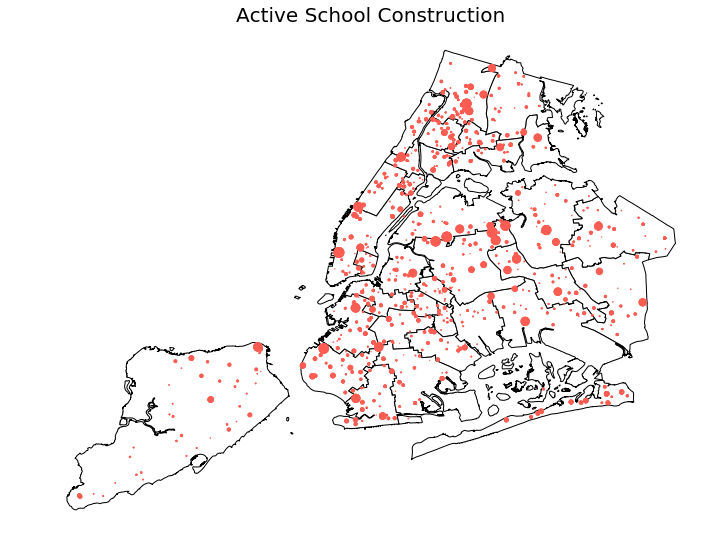

In [157]:
#plot school construction over school districts
#scale markersize by the "construction award" column

fig, ax = plt.subplots(figsize=(12,12))
ax.set_aspect('equal')
ax.axis('off')
plt.title("Active School Construction", fontsize=20)

sd.plot(facecolor='w', edgecolor='k', ax=ax)

active_geo.plot(c='#FC5D52', markersize=(active_geo['Construction Award']/1000000),  ax=ax);

In [158]:
active_geo['Project Description'].unique()

array(['Addition', 'Demo', 'New', 'Lease', 'Interior',
       'PLANYC BOILER CNVRSN/PLANYC CLIMATE CTRL',
       'WATER PENETRATION/PLANYC BOILER/PLANYC CLIMATE',
       'SANDY - INSTALL TEMPORARY BOILERS',
       'FY16 RESO A PLAYGROUND REDVELOPMENT',
       'ROOFS/PARAPETS/EXT MASONRY/EXT DOORS',
       'FULL PROGRAM ACCESSIBILITY/LOW VOLTAGE ELECTRICAL',
       'FY13 RESO A PLAYGROUND REDEVELOPMENT',
       'EXTERIOR MASONRY/PARAPETS', 'KITCHEN FLOORING/FLOOD/ANSUL SYSTEM',
       'PLANYC BOILER/PLANYC CLIMATE CTRL/FIRE ALARM',
       'AUDITORIUM UPGRADE',
       'PARAPETS/FLOOD ELIMINATION/ROOFS/MASONRY/GYM UPG',
       'PUBLIC ADDRESS SYSTEM REPLACEMENT',
       'EXT MASONRY/FLOOD ELIMINATION/PARAPETS/ROOFS',
       'LOW VOLTAGE ELEC SYSTEM/ANSUL SYSTEM',
       'PLAYNYC BOILER CONVERSION/CLIMATE CONTROL',
       'PARAPET/ROOFS/EXT MASONRY',
       'WATER INFILTRATION/FLOOD/PARAPETS/ROOFS',
       'FY 15 RESO A ROOM CONVERSION', 'SCIENCE LAB UPGRADES',
       'EXTERIOR MASONRY', '

In [159]:
#create a dataframe with projects that mention sandy in the description
active_geo.dropna(subset=['Project Description'], inplace=True)
sandy = active_geo[active_geo['Project Description'].str.contains('SANDY')]

In [160]:
sandy.shape

(61, 23)

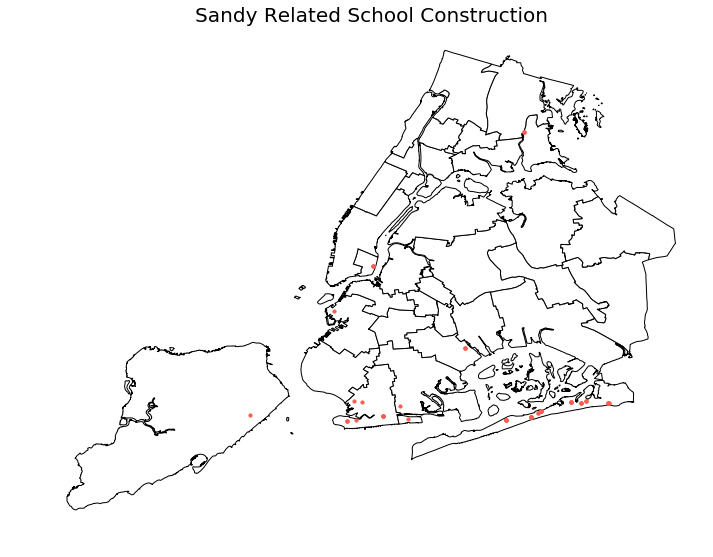

In [161]:
#plot school construction over school districts
#I don't include lat/long axes here b/c nyc borough shapes are easily recognizable

fig, ax = plt.subplots(figsize=(12,12))
ax.set_aspect('equal')
ax.axis('off')
plt.title("Sandy Related School Construction", fontsize=20)

sd.plot(facecolor='w', edgecolor='k', ax=ax)

sandy.plot(c='#FC5D52', markersize=10,  ax=ax);

In [162]:
#create a dataframe with only projects described as "New"
new_active = active_geo[active_geo['Project Description'] == 'New']

new_active.shape

(51, 23)

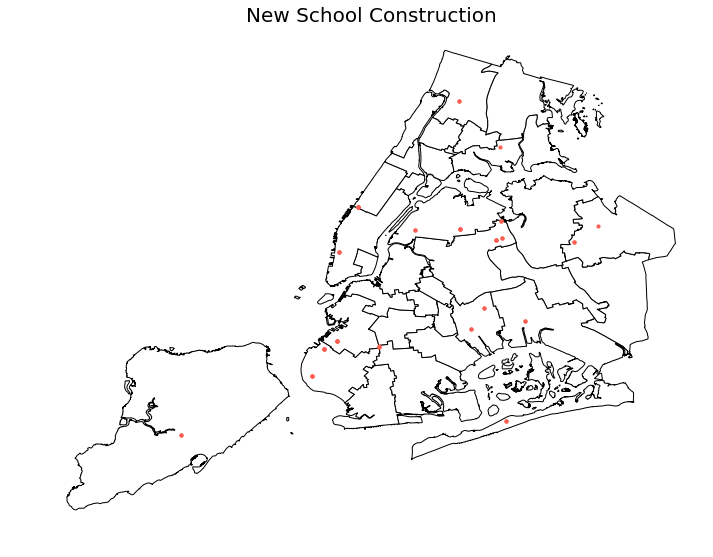

In [163]:
#plot school construction over school districts
#I don't include lat/long axes here b/c nyc borough shapes are easily recognizable

fig, ax = plt.subplots(figsize=(12,12))
ax.set_aspect('equal')
ax.axis('off')
plt.title("New School Construction", fontsize=20)

sd.plot(facecolor='w', edgecolor='k', ax=ax)

new_active.plot(c='#FC5D52', markersize=10,  ax=ax);

## bring in census information! 

In [164]:
myAPI = '90341a28f02794c77f6e3abb153a4952a0bb480b'

key_pov_house = 'B17017_002E'
key_total_house = 'B17017_001E' #2017
unemploy = 'S2301_C04_021E'
num_adults = 'S2301_C01_021E'
less_highschool = 'S2301_C01_032E'
total_edu = 'S2301_C01_031E'
five_to_14 = 'S0101_C01_020E'
fifteen_to_17 = 'S0101_C01_021E'
total_pop = 'S0101_C01_001E'
income = 'B19013G_001E'
year ='2017'


url = "https://api.census.gov/data/" + year + "/acs/acs5?get=" + key_pov_house +\
    ','+ key_total_house + ',' + income + ",NAME&for=zip%20code%20tabulation%20area:*&key=" + myAPI
resp = requests.request('GET', url).content
pov_zip = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pov_zip = pov_zip.drop(['Unnamed: 5','NAME'], axis=1)
pov_zip = pov_zip.rename(columns={key_pov_house:'house_in_pov'+year, key_total_house:'acs_total_house'+year,
                                  income:'med_house_income', 'zip code tabulation area':'zip'})


url = "https://api.census.gov/data/" + year + "/acs/acs5/subject?get=NAME,"  + unemploy +\
    ',' + num_adults+ ','+ total_edu + ',' + less_highschool + ',' + total_pop +','\
        + five_to_14 + ',' + fifteen_to_17 + "&for=zip%20code%20tabulation%20area:*&key=" + myAPI
resp = requests.request('GET', url).content
subject_data = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
subject_data = subject_data.drop(['Unnamed: 9','NAME'], axis=1)
subject_data = subject_data.rename(columns={unemploy:'unemployment_rate'+year, num_adults:'number_adults'+year,
                                  less_highschool:'no_highschool'+year , total_edu:'total_edu', total_pop:'total_pop',
                                    five_to_14:'5-14 pop', fifteen_to_17:'15-17 pop', 'zip code tabulation area':'zip'})

data = pov_zip.merge(subject_data, on='zip')
data.head()

,house_in_pov2017,acs_total_house2017,med_house_income,zip,unemployment_rate2017,number_adults2017,total_edu,no_highschool2017,total_pop,5-14 pop,15-17 pop
0,3677,5818,-666666666,601,40.5,10190,8972,2498,17599,2324,775
1,6781,12719,14871,602,17.5,23914,21163,5403,39209,4433,1593
2,9702,19009,19756,603,22.1,28585,25391,5436,50135,6038,2017
3,1157,1959,-666666666,606,12.0,3722,3279,1389,6304,724,290
4,4144,9120,21744,610,14.3,16044,14120,3215,27590,3241,1160


In [165]:
data['%no_diploma'] = np.round((data['no_highschool2017']/data['total_edu'])*100,1)
data['house_pov_rate'] = np.round((data['house_in_pov2017']/data['acs_total_house2017'])*100,1)
data['perc_school_age'] = np.round(((data['5-14 pop'] + data['15-17 pop'])/data['total_pop'])*100)
#data.head()

In [166]:
#https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u
#read in zipcode shapefile from NYC open data

url ='https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'

zips = gp.GeoDataFrame.from_file(url)

zips.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [167]:
zips.crs

{'init': 'epsg:2263'}

In [168]:
#this will create an error - let's figure out how to fix it! 
zip_and_census = zips.merge(data, left_on=zips['ZIPCODE'].astype('int'), right_on='zip')
zip_and_census.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,house_in_pov2017,acs_total_house2017,med_house_income,zip,unemployment_rate2017,number_adults2017,total_edu,no_highschool2017,total_pop,5-14 pop,15-17 pop,%no_diploma,house_pov_rate,perc_school_age
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",556,5628,69514,11436,10.3,13551,11858,2097,20905,2811,775,17.7,9.9,17.0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",6440,24731,28807,11213,8.4,41960,36240,5335,66503,8010,2781,14.7,26.0,16.0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",12214,31484,26548,11212,16.2,50546,44917,8659,82831,10433,3394,19.3,38.8,17.0
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",4004,23462,93750,11225,9.5,39369,34924,3441,59497,6422,1705,9.9,17.1,14.0
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",4598,24967,84698,11218,6.1,45305,40724,6237,76960,11265,2846,15.3,18.4,18.0


In [169]:
zips.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 13 columns):
ZIPCODE       263 non-null object
BLDGZIP       263 non-null object
PO_NAME       263 non-null object
POPULATION    263 non-null float64
AREA          263 non-null float64
STATE         263 non-null object
COUNTY        263 non-null object
ST_FIPS       263 non-null object
CTY_FIPS      263 non-null object
URL           263 non-null object
SHAPE_AREA    263 non-null float64
SHAPE_LEN     263 non-null float64
geometry      263 non-null object
dtypes: float64(4), object(9)
memory usage: 26.8+ KB


''

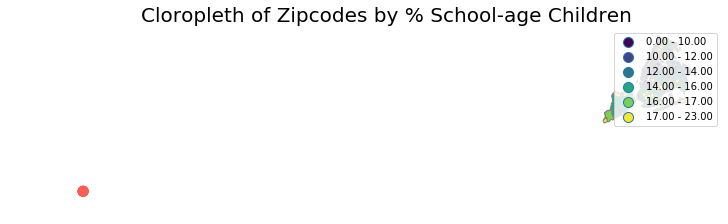

In [170]:
# this is going to create an error! let's investigate

fig, ax = plt.subplots(figsize=(12,12))
ax.axis('off')
plt.title("Cloropleth of Zipcodes by % School-age Children", fontsize=20)

zip_and_census.dropna().plot(column="perc_school_age",scheme='quantiles', k=6, cmap='viridis',legend=True,
                facecolor='k', edgecolor='grey', ax=ax)

#leg = ax.get_legend()
#leg.set_bbox_to_anchor((0.2, 0.8, 0.2, 0.2))

active_geo.plot(c='#FC5D52', markersize=(active_geo['Construction Award']/1000000),  ax=ax)
;

In [171]:
active_geo.crs

{'init': 'epsg:4326', 'no_defs': True}

In [172]:
zip_and_census.to_crs(epsg=4326, inplace=True)

color-map options for matplotlib: https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html

''

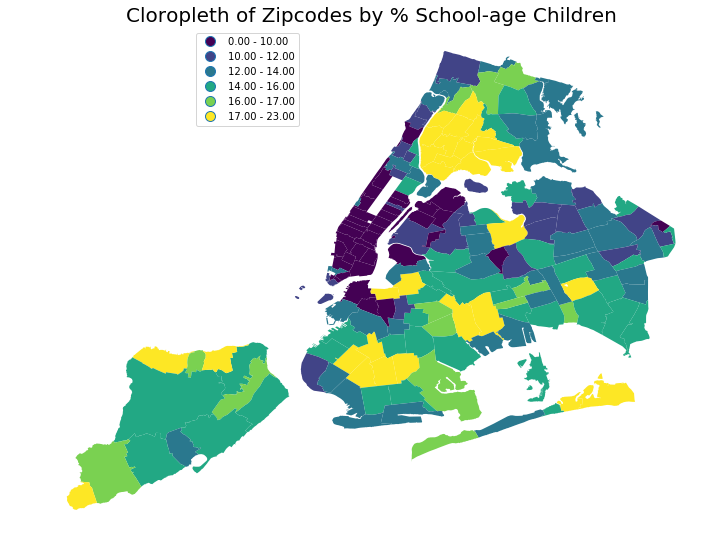

In [173]:
fig, ax = plt.subplots(figsize=(12,12))
ax.axis('off')
plt.title("Cloropleth of Zipcodes by % School-age Children", fontsize=20)

zip_and_census.dropna().plot(column="perc_school_age",scheme='quantiles', k=6, cmap='viridis',legend=True,
                edgecolor=None, ax=ax)

leg = ax.get_legend()
leg.set_bbox_to_anchor((0.2, 0.8, 0.2, 0.2))

#active_geo.plot(c='#FC5D52', markersize=(active_geo['Construction Award']/1000000),  ax=ax)
#sd.plot(facecolor='none', edgecolor='k', linewidth=2,ax=ax)
;

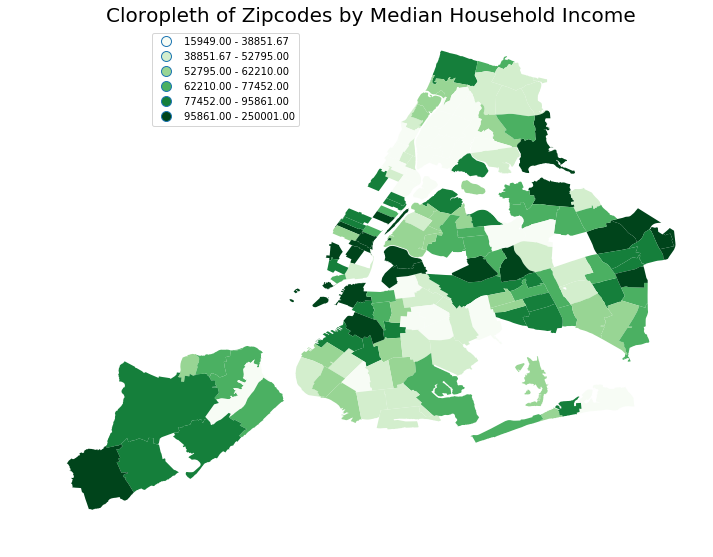

In [174]:
#lets see what zicodes people in our sample live in


fig, ax = plt.subplots(figsize=(12,12))
ax.axis('off')
plt.title("Cloropleth of Zipcodes by Median Household Income", fontsize=20)

zip_and_census.dropna()[zip_and_census['med_house_income']>0].plot(column='med_house_income',
                scheme='quantiles', k=6, cmap='Greens',legend=True, edgecolor=None, ax=ax)

leg = ax.get_legend()
leg.set_bbox_to_anchor((0.2, 0.8, 0.2, 0.2))

#active_geo.plot(c='#FC5D52', markersize=(active_geo['Construction Award']/1000000),  ax=ax)
#sd.plot(facecolor='none', edgecolor='k', linewidth=2,ax=ax);

In [175]:
zip_and_census.columns

Index(['ZIPCODE', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry', 'house_in_pov2017', 'acs_total_house2017',
       'med_house_income', 'zip', 'unemployment_rate2017', 'number_adults2017',
       'total_edu', 'no_highschool2017', 'total_pop', '5-14 pop', '15-17 pop',
       '%no_diploma', 'house_pov_rate', 'perc_school_age'],
      dtype='object')

### what if we want to aggregate the census information by school district?

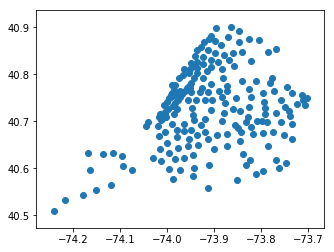

In [176]:
zip_and_census['centroid'] = zip_and_census.centroid

zip_and_census = zip_and_census.set_geometry('centroid')

zip_and_census.plot();

In [177]:
sd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 4 columns):
school_dis    33 non-null float64
shape_area    33 non-null float64
shape_leng    33 non-null float64
geometry      33 non-null object
dtypes: float64(3), object(1)
memory usage: 1.1+ KB


In [178]:
joined = gp.sjoin(zip_and_census, sd, how='left')

joined_grouped = gp.sjoin(zip_and_census[zip_and_census['med_house_income']>0], 
                          sd, how='left').groupby('school_dis').mean().reset_index()

joined_grouped.head()

,school_dis,POPULATION,AREA,SHAPE_AREA,SHAPE_LEN,house_in_pov2017,acs_total_house2017,med_house_income,zip,unemployment_rate2017,number_adults2017,total_edu,no_highschool2017,total_pop,5-14 pop,15-17 pop,%no_diploma,house_pov_rate,perc_school_age,index_right,shape_area,shape_leng
0,1.0,68591.500000,2.090925e+07,0.0,0.0,5679.500000,30080.000000,74563.000000,10002.500000,6.300000,44117.500000,39080.500000,5889.000000,66480.000000,3652.000000,1207.000000,13.450000,17.750000,7.000000,17.0,3.516075e+07,28641.276279
1,2.0,26251.555556,1.064023e+07,0.0,0.0,1313.611111,14526.444444,115317.055556,10026.666667,3.916667,19482.166667,17759.055556,567.722222,27513.777778,1573.888889,368.222222,3.744444,8.666667,7.444444,31.0,2.804004e+08,212406.819436
2,3.0,65183.500000,1.536186e+07,0.0,0.0,5285.000000,28973.500000,70791.500000,10025.500000,6.700000,44265.000000,39542.500000,3564.500000,67243.500000,5715.000000,1322.500000,10.250000,20.350000,11.000000,14.0,1.134889e+08,52072.051321
3,4.0,49090.333333,2.063465e+07,0.0,0.0,6708.000000,19946.666667,37720.666667,10033.000000,10.133333,32885.000000,28709.666667,6657.333333,50532.666667,5395.333333,1754.333333,24.433333,34.633333,13.666667,19.0,5.262043e+07,52061.828459
4,5.0,31631.000000,1.201524e+07,0.0,0.0,3827.250000,14188.250000,43082.500000,10033.250000,11.100000,23551.750000,19897.750000,3097.000000,35978.750000,3799.750000,1064.500000,15.850000,26.800000,13.750000,15.0,5.251977e+07,44469.588221


In [179]:
sd = sd.merge(joined_grouped, on='school_dis')

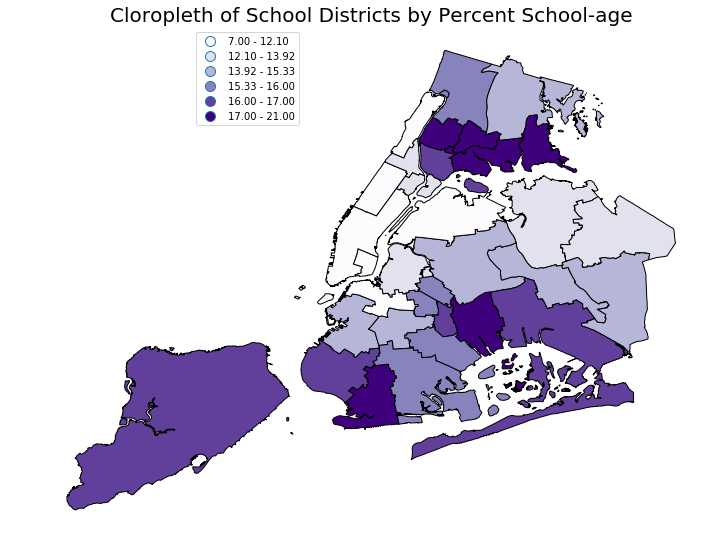

In [180]:
#https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html

fig, ax = plt.subplots(figsize=(12,12))
ax.axis('off')
plt.title("Cloropleth of School Districts by Percent School-age", fontsize=20)

sd.plot(column='perc_school_age',
                scheme='quantiles', k=6, cmap='Purples',legend=True, edgecolor='k', ax=ax)

leg = ax.get_legend()
leg.set_bbox_to_anchor((0.2, 0.8, 0.2, 0.2))

#active_geo.plot(c='#FC5D52', markersize=(active_geo['Construction Award']/1000000),  ax=ax);